# Development Notebook

This notebook is intended to develop and test some code required for the **iWander** package.  Due to its nature it cannot be executed sequentially.

Some of the codes used here when mature are converted into routines in the dev/analysis.py 

In [ ]:
import sys
sys.path.append("/home/local-python/lib/python3.5/site-packages")
sys.path.append("/home/iwander/.local/lib/python3.5/site-packages")
from iwander import *
from scipy.stats import norm as gaussian
from scipy import signal
import glob
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import astropy.coordinates as coord                                                                                                                                                                                                                                            
import astropy.units as u 
import glob
from scipy.stats import maxwell

%matplotlib nbagg

MSUN=2e30
GCONST=6.67e-11
def uniform(a,b):
    return a+np.random.rand()*(b-a)

#Maxwellian
def maxwellDistrib(x,mu=1):
    f=np.sqrt(2/np.pi)
    a=mu/(2*f)
    p=f*x**2*np.exp(-x**2/(2*a**2))/a**3
    return p

def wFunction(d,h):
    """                                                                                                                                                                              
    Schoenber B-spline function                                                                                                                                                      
    See: https://arxiv.org/pdf/1012.1885.pdf                                                                                                                                         
                                                                                                                                                                                     
    Plot:                                                                                                                                                                            
        h=0.1                                                                                                                                                                        
        sigma=wNormalization(h)                                                                                                                                                      
        fig=plt.figure()                                                                                                                                                             
        ax=fig.gca()                                                                                                                                                                 
        ds=np.linspace(0,5*h,100)                                                                                                                                                    
        ws=np.array([sigma*wFunction(d,h) for d in ds])                                                                                                                              
        ax.plot(ds,ws)                                                                                                                                                               
        fig.savefig("scratch/weighting-shoenberg.png")                                                                                                                               
                                                                                                                                                                                     
    Test it:                                                                                                                                                                         
        from scipy.integrate import quad                                                                                                                                             
        wnorm=lambda d:wFunction(d,h)*sigma                                                                                                                                          
        print quad(wnorm,0,2*h)                                                                                                                                                      
    """
    q=d/h
    if q<1:w=0.25*(2-q)**3-(1-q)**3
    elif q<2:w=0.25*(2-q)**3
    else:w=0
    return w

def wNormalization(h):
    from scipy.integrate import quad
    sigma=1/quad(wFunction,0,2*h,args=(h,))[0]
    return sigma

def wFunction2(d,h):
    q=d/h
    w=1/h**3*np.exp(-d**2/h**2)
    return w

def wNormalization2(h):
    from scipy.integrate import quad
    sigma=1/quad(wFunction2,0,2*h,args=(h,))[0]
    return sigma



## Global definitions

In [ ]:
BASE_DIR="../"
#%matplotlib inline
%matplotlib nbagg

## Elements of surrogate objects

In [394]:
wobjs=pd.read_csv(BD+"wanderer.csv")
#wobjs=pd.read_csv(BD+"wanderer.csv.diagonal")
#wobjs=pd.read_csv(BD+"wanderer.csv.nodiagonal")
nominal=wobjs.iloc[0]
print(wobjs.columns)

Index(['i', 'qo', 'eo', 'inco', 'Wo', 'wo', 'Mo', 'to', 'muo', 'qasy', 'easy',
       'incasy', 'Wasy', 'wasy', 'Masy', 'tasy', 'mu', 'ting', 'xecl', 'yecl',
       'zecl', 'vxecl', 'vyecl', 'vzecl', 'xsky', 'ysky', 'zsky', 'vxsky',
       'vysky', 'vzsky', 'xgal', 'ygal', 'zgal', 'vxgal', 'vygal', 'vzgal',
       'RA', 'DEC', 'l', 'b', 'dummy'],
      dtype='object')


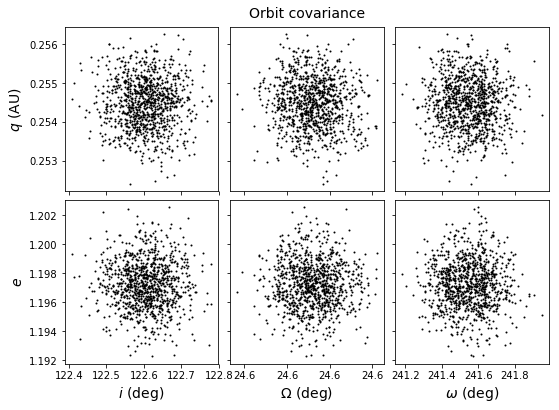

In [395]:
fig,axs=subPlots([1,1],l=0.12,b=0.2,ncols=3,dh=0.02,dw=0.02,figsize=(8,3))
args=dict(marker='o',color='k',ms=1,lw=0)
fsize=14

ax=axs[0][0]
ax.plot(wobjs.inco*RAD,wobjs.eo,**args)
ax.set_ylabel(r'$e$',fontsize=fsize)
ax.set_xlabel(r'$i$ (deg)',fontsize=fsize)

ax=axs[1][0]
ax.plot(wobjs.Wo*RAD,wobjs.eo,**args)
ax.set_xlabel(r'$\Omega$ (deg)',fontsize=fsize)
ax.set_yticklabels([])

ax=axs[2][0]
ax.plot(wobjs.wo*RAD,wobjs.eo,**args)
ax.set_xlabel(r'$\omega$ (deg)',fontsize=fsize)
ax.set_yticklabels([])

for ax in axs[0][0],axs[1][0],axs[2][0]:
    ax.tick_params(axis='both',which='major',labelsize=10)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax=axs[0][1]
ax.plot(wobjs.inco*RAD,wobjs.qo/AU,**args)
ax.set_ylabel(r'$q$ (AU)',fontsize=fsize)
ax.set_xticklabels([])

ax=axs[1][1]
ax.plot(wobjs.Wo*RAD,wobjs.qo/AU,**args)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax=axs[2][1]
ax.plot(wobjs.wo*RAD,wobjs.qo/AU,**args)
ax.set_xticklabels([])
ax.set_yticklabels([])

axs[1][1].set_title("Orbit covariance",position=(0.5,1.02),fontsize=14)

fig.savefig(FIGDIR+"wanderer-elements-diagonal.png")

## Position of the radiant

DEC =  34.147397388 0.0713627767597
RA =  280.153986922 0.196993761504
b =  16.9012410599 0.140051313863
l =  63.1642298349 0.114772359999
0.692898488252
-0.693038630723


Text(0.5,0.9,'Velocity at ingress: (U,V,W) = ($-11.320\\pm0.078$,$-22.380\\pm0.077$, $-7.618\\pm0.087$) pc')

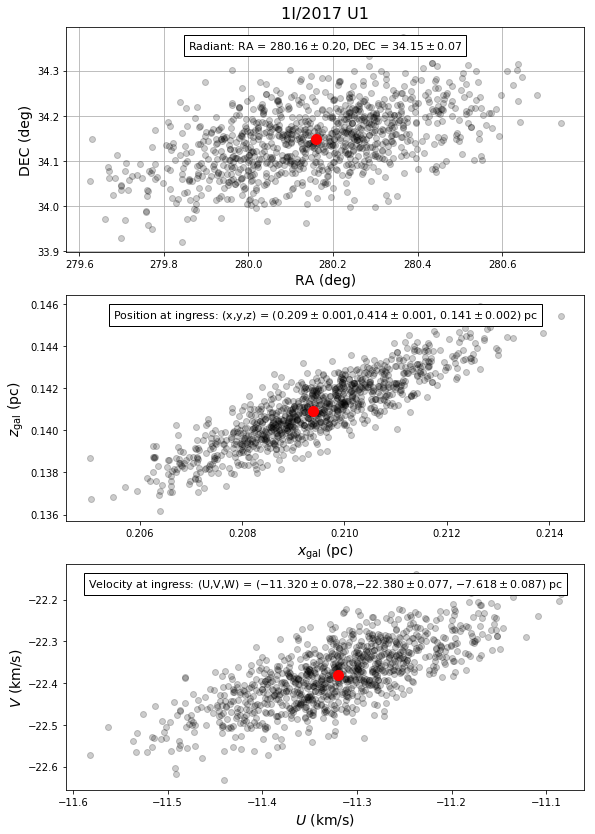

In [399]:
fig,axs=subPlots([1,1,1],dh=0.05,figsize=(9,4))

dec_error=wobjs.DEC.std()
ra_error=wobjs.RA.std()
dec_mean=wobjs.DEC.mean()
ra_mean=wobjs.RA.mean()

b_error=wobjs.b.std()
l_error=wobjs.l.std()
b_mean=wobjs.b.mean()
l_mean=wobjs.l.mean()

print("DEC = ",dec_mean,dec_error)
print("RA = ",ra_mean,ra_error)

print("b = ",b_mean,b_error)
print("l = ",l_mean,l_error)

ax=axs[0][-1]
ax.plot(wobjs.RA,wobjs.DEC,'ko',alpha=0.2)
ax.plot(wobjs.RA[0],wobjs.DEC[0],'ro',ms=10)

ax.set_xlabel("RA (deg)",fontsize=14)
ax.set_ylabel("DEC (deg)",fontsize=14)

ax.text(0.5,0.90,r"Radiant: RA = $%.2f\pm%.2f$, DEC = $%.2f\pm%.2f$"%(wobjs.RA[0],ra_error,
                                                                       wobjs.DEC[0],dec_error),
        transform=ax.transAxes,bbox=dict(fc='white'),fontsize=11,ha='center')

ax.set_title('1I/2017 U1',position=(0.5,1.01),fontsize=16)
ax.grid()

ax=axs[0][-2]
xecl=wobjs.xgal/PARSEC;yecl=wobjs.ygal/PARSEC;zecl=wobjs.zgal/PARSEC;
dx=xecl.std();dy=yecl.std();dz=zecl.std();

print(dx/xecl.mean()*100)

ax.plot(xecl,zecl,'ko',alpha=0.2)
ax.plot(xecl[0],zecl[0],'ro',ms=10)
ax.set_xlabel(r'$x_{\rm gal}$ (pc)',fontsize=14)
ax.set_ylabel(r'$z_{\rm gal}$ (pc)',fontsize=14)

ax.text(0.5,0.90,r"Position at ingress: (x,y,z) = ($%.3f\pm%.3f$,$%.3f\pm%.3f$, $%.3f\pm%.3f$) pc"%(xecl[0],dx,yecl[0],dy,zecl[0],dz),
        transform=ax.transAxes,bbox=dict(fc='white'),fontsize=11,ha='center')

ax=axs[0][-3]
vx=wobjs.vxgal;vy=wobjs.vygal;vz=wobjs.vzgal;
dvx=vx.std();dvy=vy.std();dvz=vz.std();

print(dvx/vx.mean()*100)

ax.plot(vx,vy,'ko',alpha=0.2)
ax.plot(vx[0],vy[0],'ro',ms=10)
ax.set_xlabel(r'$U$ (km/s)',fontsize=14)
ax.set_ylabel(r'$V$ (km/s)',fontsize=14)

ax.text(0.5,0.90,r"Velocity at ingress: (U,V,W) = ($%.3f\pm%.3f$,$%.3f\pm%.3f$, $%.3f\pm%.3f$) pc"%(vx[0],dvx,vy[0],dvy,vz[0],dvz),
        transform=ax.transAxes,bbox=dict(fc='white'),fontsize=11,ha='center')

## Development area

Since **iwander.py** library cannot be updated, while developing all global definitions and codes should be written in the following area

In [362]:
from matplotlib.ticker import FormatStrFormatter

#CONSTANTS
AU=1.496e8 #km
YEAR=365.25*86400
PARSEC=1/(1/3600.0*np.pi/180)*AU

DEG=np.pi/180
RAD=1/DEG

FIGDIR="figures/"

#ROUTINES
def figure(qax=True,**figopts):
    default=dict(qax=True)
    fig=plt.figure(**figopts)
    if qax:ax=fig.add_subplot(111)
    else:ax=None
    return fig,ax

def subPlots(panels,ncols=1,l=0.1,b=0.1,w=0.8,figsize=(8,6),dh=None,dw=None,fac=2.0):
    """
    Subplots
    """
    import numpy
    npanels=len(panels)
    spanels=sum(panels)

    # GET SIZE OF PANELS
    b=b/npanels
    if dh is None:dh=[b/2]*npanels
    elif type(dh) is not list:dh=[dh]*npanels
    else:
        dh+=[0]

    if dw is None:dw=w/5
        
    # EFFECTIVE PLOTTING REGION
    hall=(1-fac*b-sum(dh))
    hs=(hall*numpy.array(panels))/spanels
    fach=(1.0*max(panels))/spanels

    # SEE IF THERE IS MORE THAN ONE COLUMN
    wc=w/ncols if ncols>1 else w
    
    # CREATE AXES
    fig=plt.figure(figsize=(figsize[0],figsize[1]/fach))
    axs=[]
    
    bo=b
    axc=[]
    for i in range(npanels):
        ax=fig.add_axes([l,b,wc,hs[i]])
        axc+=[ax]
        b+=hs[i]+dh[i]
    axs+=[axc]
        
    b=bo
    if ncols>1:
        for j in range(ncols-1):
            b=bo
            l+=wc+dw
            axc=[]
            for i in range(npanels):
                ax=fig.add_axes([l,b,wc,hs[i]])
                axc+=[ax]
                b+=hs[i]+dh[i]
            axs+=[axc]
            
    return fig,axs

30857215014565.617


## Encounters

In [69]:
dataen=pd.read_csv(BD+"encounters.csv")

In [74]:
dmins=dataen.dmin[dataen.dmin<1000]

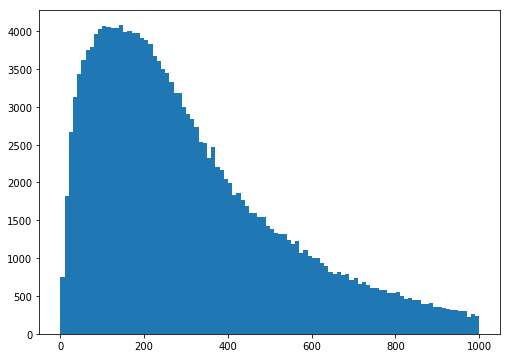

In [75]:
fig,axs=subPlots([1])

ax=axs[0][0]
rs=ax.hist(dmins,100)

In [65]:
datacan=pd.read_csv(BD+"candidates.csv")

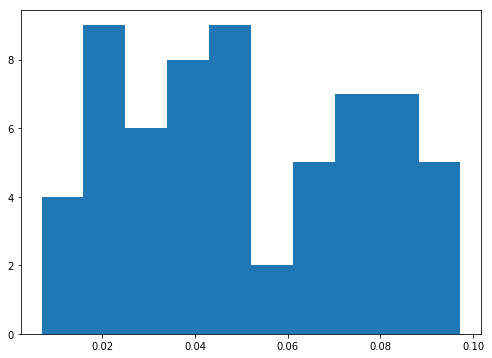

In [66]:
fig,axs=subPlots([1])

ax=axs[0][0]
rs=ax.hist(datacan.dmin/datacan.d)

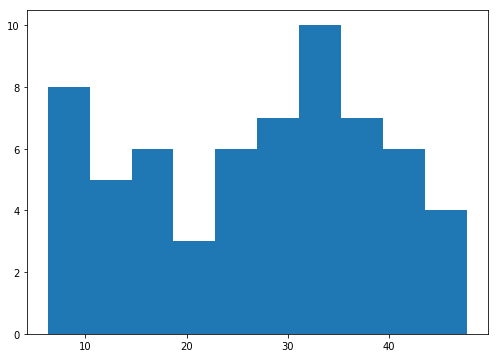

In [67]:
fig,axs=subPlots([1])
vrels=datacan.vrel[datacan.vrel<100]

ax=axs[0][0]
rs=ax.hist(vrels)

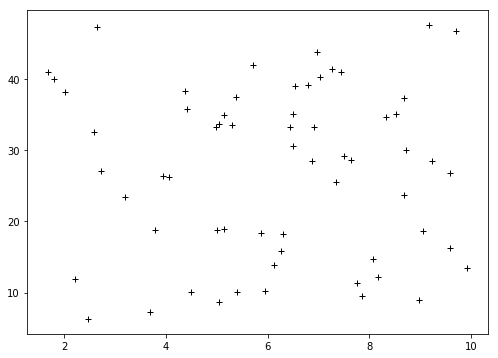

In [68]:
fig,axs=subPlots([1])

ax=axs[0][0]

ax.plot(datacan.dmin,datacan.vrel,'k+')

#ax.set_ylim((0,100))

In [78]:
vt=2*np.pi/(7*3600)*100

In [79]:
vt**2/100

6.2166820364634394e-06

In [80]:
vt

0.02493327502849042

## Ejection distributions

In [41]:
data=np.loadtxt("ejection-results.data")
aps=np.unique(data[:,0]);na=len(aps)
Mps=np.unique(data[:,1]);nM=len(Mps)
vmean_data=data[:,2].reshape(na,nM)
vstd_data=data[:,3].reshape(na,nM)
print("Number of data points: N(a) = %d, N(Mp) = %d"%(na,nM))
print("Values of ap:",aps)
print("Values of Mp:",Mps)

Number of data points: N(a) = 24, N(Mp) = 21
Values of ap: [ 0.5  0.7  0.9  1.1  1.3  1.5  1.7  1.9  2.1  2.3  2.5  2.7  2.9  3.1  3.3
  3.5  3.7  3.9  4.1  4.3  4.5  4.7  4.9  5.1]
Values of Mp: [ 0.0001      0.0001216   0.00014788  0.00017982  0.00021867  0.00026591
  0.00032336  0.00039322  0.00047818  0.00058148  0.00070711  0.00085987
  0.00104564  0.00127154  0.00154625  0.0018803   0.00228653  0.00278051
  0.00338122  0.0041117   0.005     ]


(0, 5)

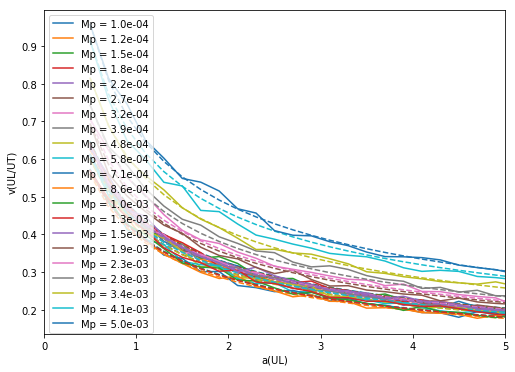

In [42]:
fig,axs=subPlots([1])

ax=axs[0][0]
fs=[]
for i,M in enumerate(Mps):
    line,=ax.plot(aps,vmean_data[:,i],label='Mp = %.1e'%Mps[i])
    f=vmean_data[0,i]*np.sqrt(aps[0])
    ax.plot(aps,f*np.sqrt(1/aps),'k--',color=line.get_color())
    fs+=[f]
    
ax.legend(loc='best')
ax.set_xlabel('a(UL)')
ax.set_ylabel('v(UL/UT)')
ax.set_xlim((0,5))

In [43]:
vs=[]
hs=[]
xs=[]
Mpps=[]
apps=[]
for file in glob.glob("data/*ap_5.0e+00*.data"):
    parts=file.split("--")
    Mp=float(parts[1].replace("Mp_",""))
    ap=float(parts[2].replace("ap_",""))
    vinfs=np.loadtxt(file)
    h,x=np.histogram(vinfs,30,normed=True)
    vmean=vinfs.mean()
    vstd=vinfs.std()
    vs+=[vinfs]
    hs+=[h]
    xs+=[x]
    Mpps+=[Mp]
    apps+=[ap]
    print("Velocity distribution for Mp = %e, ap = %e: vmean = %e, sigmav = %e"%(Mp,ap,vmean,vstd))
    
iargs=np.argsort(Mpps)
Mpps=np.array(Mpps)[iargs]
apps=np.array(apps)[iargs]
xs=np.array(xs)[iargs]
hs=np.array(hs)[iargs]
vs=np.array(vs)[iargs]

Velocity distribution for Mp = 1.000000e-02, ap = 5.000000e+00: vmean = 4.004175e-01, sigmav = 1.459988e-01
Velocity distribution for Mp = 1.000000e-03, ap = 5.000000e+00: vmean = 1.879614e-01, sigmav = 1.120181e-01
Velocity distribution for Mp = 5.000000e-03, ap = 5.000000e+00: vmean = 2.999224e-01, sigmav = 1.254320e-01


Text(0.5,1,'$a_p=5.0\\;u_L$')

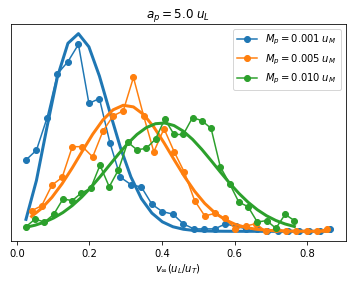

In [50]:
fig=plt.figure()
ax=fig.gca()

for i in range(len(vs)):
    Mp=Mpps[i]
    ap=apps[i]
    vinfs=vs[i]
    x=xs[i]
    h=hs[i]
    vmean=vinfs.mean()
    vstd=vinfs.std()
    xm=(x[1:]+x[:-1])/2
    line,=ax.plot(xm,h,'o-',label='$M_p=%.3f\;u_M$'%Mp)
    if Mp<5e-3:
        pt=h.sum()*(xm[1]-xm[0])*maxwellDistrib(xm,vmean)
    else:
        pt=h.sum()*(xm[1]-xm[0])*gaussian.pdf(xm,vmean,vstd)
    ax.plot(xm,pt,'-',lw=3,color=line.get_color())

ax.set_xlabel("$v_\infty$($u_L/u_T$)")
ax.set_yticks([])
ax.legend(loc='best')
ax.set_title("$a_p=%.1f\;u_L$"%apps[0])

In [832]:
UL=1*AU*1e3
UM=0.5*MSUN
UT=np.sqrt(UL**3/(GCONST*UM))
UV=UL/UT

In [199]:
print("UL=",UL,",UM=",UM)
print("UT=",UT,",UV=",UV)

UL= 149600000000.0 ,UM= 1e+30
UT= 7084912.21184 ,UV= 21115.2933907


In [200]:
MPS,APS=np.meshgrid(Mps,aps)
print(MPS.shape,APS.shape,vmean_data.shape)

(24, 21) (24, 21) (24, 21)


/home/local-python/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


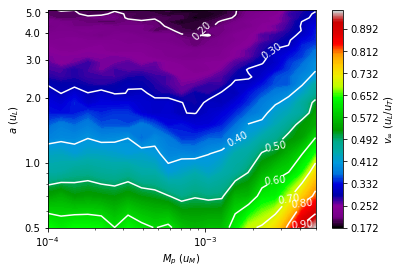

In [215]:
fig=plt.figure()
ax=fig.gca()

c=ax.contourf(MPS,APS,vmean_data,200,cmap='spectral')
cb=fig.colorbar(c)
cb.set_label("$v_\infty$ ($u_L/u_T$)")

c=ax.contour(MPS,APS,vmean_data,colors='w')
ax.clabel(c,inline=True,fmt="%.2f")

ax.set_xlabel("$M_p$ ($u_M$)")
ax.set_ylabel("$a$ ($u_L$)")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_yticks([0.5,1.0,2.0,3.0,4.0,5.0])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


Text(0,0.5,'$\\Delta v/v$')

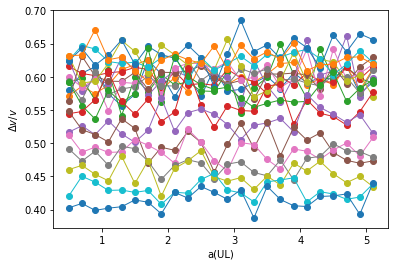

In [220]:
fig=plt.figure()
ax=fig.gca()

dvv=[]
for i,M in enumerate(Mps[::1]):
    ratio=vstd_data[:,i]/vmean_data[:,i]
    avg=ratio.mean()
    std=ratio.std()
    dvv+=[avg]
    line,=ax.plot(aps,ratio,label='Mp = %.1e'%Mps[i],marker='o',lw=1)
    #ax.axhspan(avg-std,avg+std,color=line.get_color(),alpha=0.3)

#ax.legend(loc='best')
ax.set_xlabel('a(UL)')
ax.set_ylabel('$\Delta v/v$')

Text(0.5,0,'$M_p$ ($u_M$)')

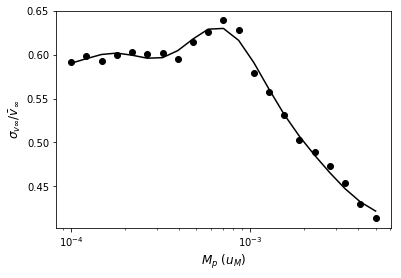

In [224]:
b,a=signal.butter(10,0.325)
sdv=signal.filtfilt(b,a,dvv,padlen=6)
fig=plt.figure()
ax=fig.gca()

ax.plot(Mps,dvv,'ko')
ax.plot(Mps,sdv,'k-')
#ax.plot(Mp,0.5*np.sqrt(1e-3/Mp))

ax.set_xscale('log')
ax.set_ylabel(r"$\sigma_{v\infty}/\bar{v}_\infty$",fontsize=12)
ax.set_xlabel(r"$M_p$ ($u_M$)",fontsize=12)

## Test particle integrations

In [279]:
data=pd.read_csv(BD+"cloud.csv")

In [280]:
data.columns

Index(['t', 'part0-R', 'part0-phi', 'part0-Z', 'part0-vR', 'part0-dphi',
       'part0-vZ', 'part0-x', 'part0-y', 'part0-z', 'part0-vx', 'part0-xy',
       'part0-vz', 'dummy'],
      dtype='object')

In [281]:
ts=data["t"]
Rs=data["part0-R"]
xs=data["part0-x"]
ys=data["part0-y"]
zs=data["part0-z"]

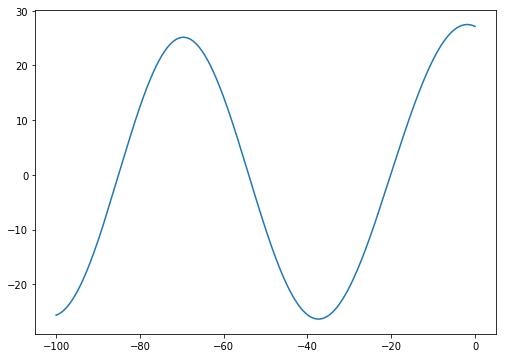

In [284]:
fig,axs=subPlots([1])
ax=axs[0][0]

ax.plot(ts/1e6,zs)

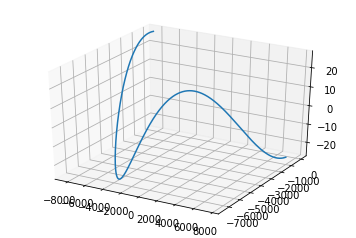

In [283]:
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')

ax.plot(xs,ys,zs)

## Potential Progenitors

In [409]:
#encounters=pd.read_csv(BD+"encounters.csv")
candidates=pd.read_csv(BASE_DIR+"candidates.csv")
progenitors=pd.read_csv(BASE_DIR+"progenitors.csv")
print("Number of progenitors:",len(progenitors))

Number of progenitors: 107


In [410]:
#progsort=progenitors.sort_values(by=['nomdmin','Psurmed'],ascending=[True,False])
progsort=progenitors.sort_values(by='Psurmed',ascending=False)
#progsort=progenitors.sort_values(by='maxdmin',ascending=True)
progsort[progsort.Pprob>0][["hip","tycho2_id","name_simbad","source",'Pprob', 'Psurmed', 'Pvelmed', 'Pdist', 'nomtmin', 'nomdmin',
       'nomvrel', 'mintmin', 'maxtmin', 'mindmin', 'maxdmin', 'minvrel',
       'maxvrel']]

,hip,tycho2_id,name_simbad,source,Pprob,Psurmed,Pvelmed,Pdist,nomtmin,nomdmin,nomvrel,mintmin,maxtmin,mindmin,maxdmin,minvrel,maxvrel
103,103749.0,NaN,HD_200325,::hipparcos:simbad,3.575875e-08,4.082873e-04,2.941887e-03,8.704900e-05,-3885076.0,0.574816,11.99014,-4924744.0,-3337882.0,0.111995,6.631072,9.859499,13.68440
90,17288.0,NaN,HD_23121,gaia::hipparcos:simbad,4.865183e-10,2.210382e-05,2.001763e-03,2.778795e-05,-6663889.0,5.452579,15.21279,-7102303.0,-5787062.0,1.500143,16.731280,14.424290,16.23221
1,NaN,6988-276-1,NaN,gaia:tycho::,3.093907e-10,1.217869e-05,1.362824e-03,2.105700e-05,-5996010.0,6.823053,16.86563,-7392341.0,-4763953.0,0.113744,53.370780,14.203510,20.00583
67,43100.0,NaN,*_iot_Cnc_B,gaia::hipparcos:simbad,3.092926e-11,1.522061e-06,3.091963e-04,2.028906e-05,-5955700.0,10.703740,16.54710,-7559157.0,-4046822.0,1.334535,21.877780,13.032450,20.70044
50,NaN,6961-156-1,NaN,gaia:tycho::,3.598365e-12,5.195197e-07,5.557050e-05,6.127841e-06,-7879194.0,6.522514,23.96788,-8426360.0,-6894295.0,0.599325,40.919900,22.528300,25.22682
101,97022.0,NaN,HD_186159,::hipparcos:simbad,1.979541e-11,4.320106e-07,7.141589e-05,6.562436e-05,-2367115.0,7.509578,23.42531,-3048557.0,-1900865.0,0.806215,12.223580,20.453270,26.19412
100,77570.0,NaN,HD_141693,::hipparcos:simbad,4.934060e-12,2.421392e-07,2.326831e-03,1.718875e-05,-8140920.0,14.409750,13.43648,-9789714.0,-5770779.0,3.816332,65.858320,9.673113,16.63249
44,NaN,9523-1571-1,NaN,gaia:tycho::,1.385658e-12,1.048545e-07,1.294780e-06,1.331767e-05,-3928409.0,1.395748,33.90712,-4655892.0,-3540418.0,0.134007,9.847638,28.744700,38.42315
73,83532.0,NaN,HD_155262,gaia::hipparcos:simbad,1.345724e-12,6.674832e-08,2.526096e-04,2.200507e-05,-5158012.0,6.123824,19.10020,-5914521.0,-4470278.0,2.697719,10.519910,16.690420,21.81124
92,63797.0,NaN,HD_113376,gaia::hipparcos:simbad,1.047983e-12,6.166882e-08,2.775617e-07,1.697228e-05,-2934247.0,0.680578,40.09615,-3435216.0,-2683762.0,0.099890,5.861952,35.717460,43.73164


In [245]:
#REFERENCE
#progsort=progenitors.sort_values(by=['nomdmin','Psurmed'],ascending=[True,False])
progsort=progenitors.sort_values(by='Psurmed',ascending=False)[progsort.Pprob>0]
progsort[["hip","tycho2_id","name_simbad","source",'Pprob', 'Psurmed', 'Pvelmed', 'Pdist', 'nomtmin', 'nomdmin',
       'nomvrel', 'mintmin', 'maxtmin', 'mindmin', 'maxdmin', 'minvrel',
       'maxvrel']]

,hip,tycho2_id,name_simbad,source,Pprob,Psurmed,Pvelmed,Pdist,nomtmin,nomdmin,nomvrel,mintmin,maxtmin,mindmin,maxdmin,minvrel,maxvrel
103,103749.0,NaN,HD_200325,::hipparcos:simbad,6.129660e-08,1.408795e-05,6.072117e-04,0.000087,-3885076.0,0.574816,11.99014,-4924744.0,-3337882.0,0.130932,6.177073,9.948161,13.68440
1,NaN,6988-276-1,NaN,gaia:tycho::,2.122247e-09,1.662189e-06,2.601602e-04,0.000021,-5996010.0,6.823053,16.86563,-7392341.0,-4763953.0,0.113744,53.108070,14.203510,19.88908
90,17288.0,NaN,HD_23121,gaia::hipparcos:simbad,1.391861e-09,1.279046e-06,3.228081e-04,0.000028,-6663889.0,5.452579,15.21279,-7102303.0,-5787062.0,1.500143,16.731280,14.424290,16.13334
67,43100.0,NaN,*_iot_Cnc_B,gaia::hipparcos:simbad,3.136566e-11,3.112091e-08,6.789592e-05,0.000020,-5955700.0,10.703740,16.54710,-7559157.0,-4046822.0,1.557425,21.860050,13.032450,20.70044
50,NaN,6961-156-1,NaN,gaia:tycho::,6.457541e-12,1.879564e-08,5.607263e-06,0.000006,-7879194.0,6.522514,23.96788,-8426360.0,-6894295.0,1.435698,40.364070,22.528300,25.20873
41,NaN,6187-522-1,NaN,gaia:tycho::,2.739152e-12,1.626319e-08,4.620339e-06,0.000003,-9926280.0,9.175828,26.23640,-12344220.0,-8144640.0,1.692602,74.063860,20.243640,34.58415
7,NaN,5222-131-1,NaN,gaia:tycho::,1.726062e-12,6.446135e-09,-2.463724e-08,0.000003,-8081802.0,31.491680,28.57822,-9877758.0,-6061352.0,1.448526,315.360000,25.122520,44.99172
44,NaN,9523-1571-1,NaN,gaia:tycho::,3.934878e-12,6.008210e-09,0.000000e+00,0.000013,-3928409.0,1.395748,33.90712,-4655892.0,-3540418.0,0.589498,9.657820,28.744700,38.31874
101,97022.0,NaN,HD_186159,::hipparcos:simbad,2.282569e-12,1.003956e-09,1.073951e-05,0.000066,-2367115.0,7.509578,23.42531,-3048557.0,-1900865.0,0.806215,12.223580,20.494900,26.17206
100,77570.0,NaN,HD_141693,::hipparcos:simbad,4.637305e-15,4.550047e-12,3.338715e-04,0.000017,-8140920.0,14.409750,13.43648,-9789714.0,-5770779.0,3.816332,65.402190,9.761381,16.63249


In [418]:
# Generate latex table
i=1
for index in progsort.index:
    p=progenitors.loc[index]
    row=""
    if str(p.hip)=='nan':
        if str(p.tycho2_id)=='nan':sid='--'
        else:sid="TYC "+str(p.tycho2_id)
    else:sid="HIP "+str(int(p.hip))
    
    bf="";mbf=""
    if p.mindmin<1 and p.maxdmin<10:
        bf="\\bf";mbf="\\mathbf"
    if np.log10(p.Psurmed)<-10:continue
    
    row+=r"%s %s & %s %s & "%(bf,sid,
                              bf,str(p.name_simbad).replace('nan','--').replace('_',' '),
                            )
    row+=r"$%s{%.1f}$ & $%s{%.1f}$ & $%s{%.0f}$ & "%(mbf,p.nomtmin/1e6,mbf,p.nomdmin,mbf,p.nomvrel)
    row+=r"$%s{[%.1f,%.1f]}$ & $%s{[%.1f,%.1f]}$ & $%s{[%.0f,%.0f]}$ & "%(mbf,p.mintmin/1e6,p.maxtmin/1e6,
                                                                    mbf,p.mindmin,p.maxdmin,
                                                                    mbf,p.minvrel,p.maxvrel)
    logPsurmed="$%s{%.1f}$"%(mbf,np.log10(p.Psurmed)) if p.Psurmed>0 else '--'
    logPvelmed="$%s{%.1f}$"%(mbf,np.log10(p.Pvelmed)) if p.Pvelmed>0 else '--'
    logPdist="$%s{%.1f}$"%(mbf,np.log10(p.Pdist)) if p.Pdist>0 else '--'
    logPprob="$%s{%.1f}$"%(mbf,np.log10(p.Pprob)) if p.Pprob>0 else '--'
    row+=r"%s & %s & %s & %s \\"%(logPsurmed,logPvelmed,logPdist,logPprob)
    print(row)
    i+=1

\bf HIP 103749 & \bf HD 200325 & $\mathbf{-3.9}$ & $\mathbf{0.6}$ & $\mathbf{12}$ & $\mathbf{[-4.9,-3.3]}$ & $\mathbf{[0.1,6.6]}$ & $\mathbf{[10,14]}$ & $\mathbf{-3.4}$ & $\mathbf{-2.5}$ & $\mathbf{-4.1}$ & $\mathbf{-7.4}$ \\
 HIP 17288 &  HD 23121 & ${-6.7}$ & ${5.5}$ & ${15}$ & ${[-7.1,-5.8]}$ & ${[1.5,16.7]}$ & ${[14,16]}$ & ${-4.7}$ & ${-2.7}$ & ${-4.6}$ & ${-9.3}$ \\
 TYC 6988-276-1 &  -- & ${-6.0}$ & ${6.8}$ & ${17}$ & ${[-7.4,-4.8]}$ & ${[0.1,53.4]}$ & ${[14,20]}$ & ${-4.9}$ & ${-2.9}$ & ${-4.7}$ & ${-9.5}$ \\
 HIP 43100 &  * iot Cnc B & ${-6.0}$ & ${10.7}$ & ${17}$ & ${[-7.6,-4.0]}$ & ${[1.3,21.9]}$ & ${[13,21]}$ & ${-5.8}$ & ${-3.5}$ & ${-4.7}$ & ${-10.5}$ \\
 TYC 6961-156-1 &  -- & ${-7.9}$ & ${6.5}$ & ${24}$ & ${[-8.4,-6.9]}$ & ${[0.6,40.9]}$ & ${[23,25]}$ & ${-6.3}$ & ${-4.3}$ & ${-5.2}$ & ${-11.4}$ \\
 HIP 97022 &  HD 186159 & ${-2.4}$ & ${7.5}$ & ${23}$ & ${[-3.0,-1.9]}$ & ${[0.8,12.2]}$ & ${[20,26]}$ & ${-6.4}$ & ${-4.1}$ & ${-4.2}$ & ${-10.7}$ \\
 HIP 77570 &  HD 141693

In [165]:
#FIRST ATTEMPT
progenitors[["hip","name_simbad","source","Pprob","parallax","parallax_Hip","dmin","nomtmin","nomdmin","mindmin","maxdmin","velrelmin"]].sort_values(by="nomdmin").head()

,hip,name_simbad,source,Pprob,parallax,parallax_Hip,dmin,nomtmin,nomdmin,mindmin,maxdmin,velrelmin
161,103749.0,HD_200325,::hipparcos:simbad,3.205546e-08,0.000000,19.29,2.45613,-3885076.0,0.478831,0.310549,7.786214,11.73455
146,63797.0,HD_113376,gaia::hipparcos:simbad,0.000000e+00,8.464321,10.59,2.20472,-2934247.0,0.520203,0.092026,2.982563,41.98247
144,17288.0,HD_23121,gaia::hipparcos:simbad,1.825728e-09,10.025797,10.92,6.18900,-6663889.0,0.687212,1.219050,13.801300,14.86001
150,18453.0,*_43_Per,::hipparcos:simbad,0.000000e+00,0.000000,24.51,2.04616,-904446.8,0.728524,0.612958,2.812651,41.46564
83,NaN,NaN,gaia:tycho::,8.157114e-13,7.479796,0.00,5.46515,-3928409.0,1.285126,1.204915,10.814780,33.88669


In [488]:
parallax=10.0
d=1/(parallax*1e-3)
print("Distance:",d)

Distance: 100.0


In [491]:
dist=0.3/3600*np.pi/180*100*206000
print("Binary distance:",dist)

Binary distance: 29.961485492569324


In [441]:
potential[["hip","tycho2_id","name_simbad","ra","ra_error","dec","dec_error","parallax","parallax_error","pmra","pmra_error","pmdec","pmdec_error","RV","eRV","l","b"]]

,hip,tycho2_id,name_simbad,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,RV,eRV,l,b
0,NaN,6978-911-1,NaN,347.674314,0.180093,-27.847338,0.144108,4.862691,0.323810,19.763900,0.905878,-16.610817,0.653017,32.760,0.629,25.231264,-67.685575
1,NaN,5907-1244-1,NaN,73.206504,0.113600,-19.917201,0.187257,16.127656,0.224871,37.815834,0.760327,-16.691572,0.633302,61.469,7.407,219.292801,-34.702594
2,NaN,5172-2349-1,NaN,300.992430,0.270462,-7.039355,0.142537,5.937269,0.436690,8.415726,1.654745,-21.093244,0.910812,16.613,2.072,34.861389,-19.316017
3,NaN,5855-2215-1,NaN,26.401155,0.542666,-18.059877,0.177087,3.837536,0.444167,17.460400,1.551883,-9.390947,0.554063,45.472,0.786,179.752669,-74.574715
4,NaN,7693-1161-1,NaN,147.149477,0.243751,-38.521808,0.236968,28.204604,0.380987,-100.365204,1.304336,6.482975,0.759690,67.929,0.781,268.052728,11.667269
5,NaN,9523-1571-1,NaN,293.353815,0.111309,-83.373595,0.165603,7.479796,0.260576,6.091397,0.627487,-37.089032,0.527859,45.659,2.209,310.324982,-28.141019
6,NaN,6961-156-1,NaN,333.676968,0.183766,-28.902393,0.153860,5.411970,0.310740,18.552904,1.017930,-21.615806,0.724449,16.344,0.820,20.619354,-55.519841
7,6711.0,NaN,HD_8671,21.578483,0.248077,43.457493,0.257165,23.297285,0.296188,108.637407,0.029468,-59.582758,0.026167,31.200,0.100,129.613374,-18.961340
8,76984.0,NaN,HD_140514,235.793322,0.183347,21.701364,0.181768,13.580618,0.258336,-36.867710,0.068109,-19.415125,0.075569,10.600,0.200,34.643129,50.716484
9,87382.0,NaN,HD_162826,267.808335,0.250138,40.072504,0.241083,29.587755,0.277417,-16.675547,0.025879,9.795455,0.030419,1.300,0.300,66.064020,28.060091


In [421]:
star=encounters[encounters["hip"]==43667.0]
star.dmin

208966    11.4723
Name: dmin, dtype: float64

In [449]:
data=pd.read_csv(BASE_DIR+"progenitors.csv")

In [450]:
len(data)

1

In [453]:
#data[["nomdmin","mindmin","maxdmin","hip","tycho2_id"]]
data

,nomdmin,nomtmin,mindmin,maxdmin,velrelmin,velrelmax,n,postarx,postary,postarz,...,ra_simbad,dec_simbad,pmra_simbad,pmdec_simbad,source,RAJ2000,DEJ2000,RV,eRV,CAT
0,10.67837,-9712328.0,3.956709,73.05565,40.50412,43.38089,319,91.902,-18.6707,-385.65,...,NaN,NaN,NaN,NaN,gaia:::,0.86342,-36.21017,47.317,1.036,RAVE-DR5.tsv


## Test Conversion

Here we are about to test the iwander routines that convert from observed properties into galactocentric properties

For a complete description of coordinate system transformation: 
    http://docs.astropy.org/en/stable/coordinates/galactocentric.html#coordinates-galactocentric

Star: TYC 6995-570-1

In [404]:
ra=0.86342775387840831
dec=-36.21023337545908305
par=2.51406002419760188
pmra=11.61562323735791225
pmdec=-7.08731846383377295
vr=47.31700000000000017

c1 = coord.ICRS(ra=ra*u.degree, dec=dec*u.degree,                                                                                                                                                                                                                    
                distance=(par*u.mas).to(u.pc, u.parallax()),                                                                                                                                                                                                                             
                pm_ra_cosdec=pmra*u.mas/u.yr,                                                                                                                                                                                                                 
                pm_dec=pmdec*u.mas/u.yr,                                                                                                                                                                                                                                                  
                radial_velocity=vr*u.km/u.s)  

In [405]:
c1.transform_to(coord.Galactocentric)

<Galactocentric Coordinate (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    ( 266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=( 11.1,  232.24,  7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in pc
    (-8209.3564291, -19.11550775, -359.83547647)
 (v_x, v_y, v_z) in km / s
    ( 8.51491295,  208.15949305, -40.8191374)>

In [352]:
-1.57293*np.cos(0.380844*np.pi/180)

-1.5728952522432993

In [389]:
c1 = coord.ICRS(ra=88.59576199999999346*u.degree, dec=20.276173000*u.degree,                                                                                                                                                                                                                    
                distance=(115.43*u.mas).to(u.pc, u.parallax()),                                                                                                                                                                                                                             
                pm_ra_cosdec=-162.53999999999999204*u.mas/u.yr,                                                                                                                                                                                                                 
                pm_dec=-99.51000000000000512*u.mas/u.yr,                                                                                                                                                                                                                                                  
                radial_velocity=-13.47*u.km/u.s)  

In [395]:
co=c1.transform_to(coord.Galactocentric)

In [396]:
print(co)

<Galactocentric Coordinate (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    ( 266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=( 11.1,  232.24,  7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in pc
    (-8308.51667619, -1.27277972,  26.61483052)
 (v_x, v_y, v_z) in km / s
    ( 24.77787473,  234.11288576,  0.03142402)>


In [400]:
print(co.v_x.value,co.v_y,co.v_z)

24.77787472783556 km / s 234.11288575649098 km / s 0.0314240199887278 km / s


In [402]:
np.array([co.v_x.value, co.v_y.value, co.v_z.value])-np.array([11.1,  232.24,  7.25])

array([ 13.67787473,   1.87288576,  -7.21857598])

## Exploring the data

In [382]:
gaia=pd.read_csv(BASE_DIR+"db/src/AstroRV.csv")

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,86,90,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [388]:
gaia[["hip","tycho2_id","source","pmra"]]

,hip,tycho2_id,source,pmra
0,NaN,55-72-1,gaia:tycho::,-1.572928
1,NaN,48-1138-1,gaia:tycho::,9.533592
2,NaN,55-1269-1,gaia:tycho::,-5.716453
3,NaN,55-1181-1,gaia:::,2.199605
4,NaN,55-1308-1,gaia:::,-25.334209
5,NaN,48-685-1,gaia:tycho::,-46.195261
6,NaN,48-120-1,gaia:tycho::,11.483705
7,NaN,48-1076-1,gaia:tycho::,19.802386
8,NaN,48-1215-1,gaia:::,-3.453327
9,NaN,55-551-1,gaia:::,-5.742096


## Surrogate and test particles

In [85]:
sur=pd.read_csv(BASE_DIR+"surrogate.csv")

Text(0,0.5,'$v_r$ (km/s)')

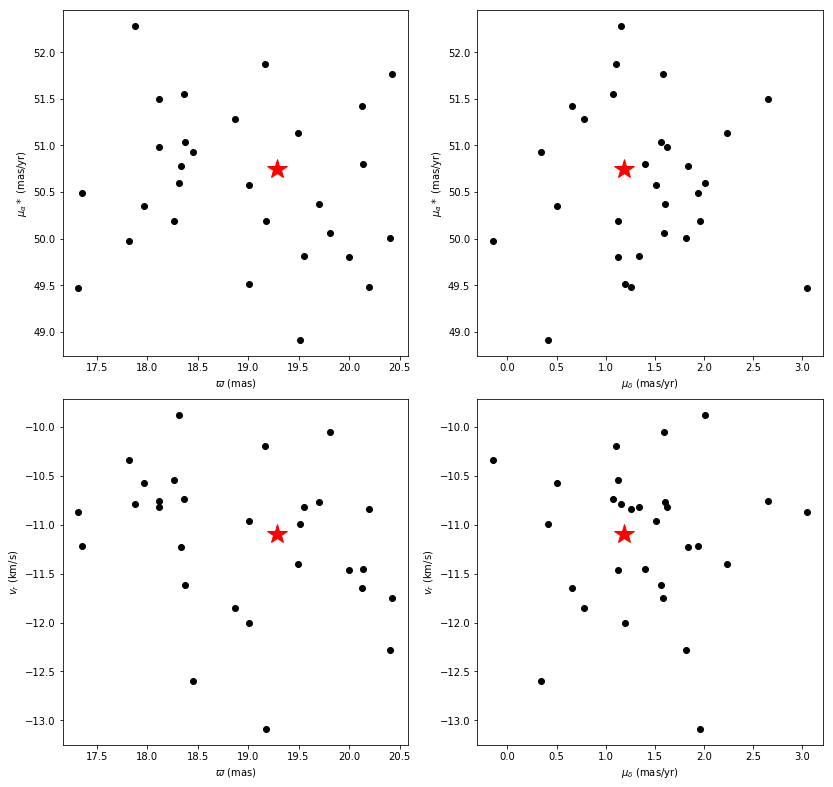

In [86]:
fig,axs=subPlots([1,1],ncols=2,dh=0.05,dw=0.08,figsize=(12,6))

ax=axs[1][1]
ax.plot(sur.mudec,sur.mura,'ko')
ax.plot(sur.mudec[0],sur.mura[0],'r*',ms=20)
ax.set_xlabel(r"$\mu_\delta$ (mas/yr)")
ax.set_ylabel(r"$\mu_\alpha*$ (mas/yr)")

ax=axs[0][1]
ax.plot(sur.par,sur.mura,'ko')
ax.plot(sur.par[0],sur.mura[0],'r*',ms=20)
ax.set_xlabel(r"$\varpi$ (mas)")
ax.set_ylabel(r"$\mu_\alpha*$ (mas/yr)")

ax=axs[0][0]
ax.plot(sur.par,sur.vr,'ko')
ax.plot(sur.par[0],sur.vr[0],'r*',ms=20)
ax.set_xlabel(r"$\varpi$ (mas)")
ax.set_ylabel(r"$v_r$ (km/s)")

ax=axs[1][0]
ax.plot(sur.mudec,sur.vr,'ko')
ax.plot(sur.mudec[0],sur.vr[0],'r*',ms=20)
ax.set_xlabel(r"$\mu_\delta$ (mas/yr)")
ax.set_ylabel(r"$v_r$ (km/s)")

In [354]:
pos=np.loadtxt(BASE_DIR+"surrogatenom.dat")
Nsur=pos.shape[0]
Npart=int((pos.shape[1]-6)/6)
print("Number of particles: ",Npart)
print("Number of surrogates:",Nsur)

Number of particles:  256
Number of surrogates: 30


In [355]:
#READ DATA ABOUT SURROGATES AND PARTICLES
rnom=[]
for i in range(Nsur):
    rnom+=[pos[i,:6]]
rnom=np.array(rnom)

rparts=[]
for i in range(Nsur):
    rps=[]
    for j in range(Npart):
        rps+=[pos[i,6*(j+1):6*(j+1)+6]]
    rparts+=[rps]
rparts=np.array(rparts)

8290.173
Average interparticle objects:  0.0363688129452
dx=1.012462e-01,dy=1.097193e-01,dz=1.934190e+00

Normalization: 0.441518748917


(-0.5, 1.0)

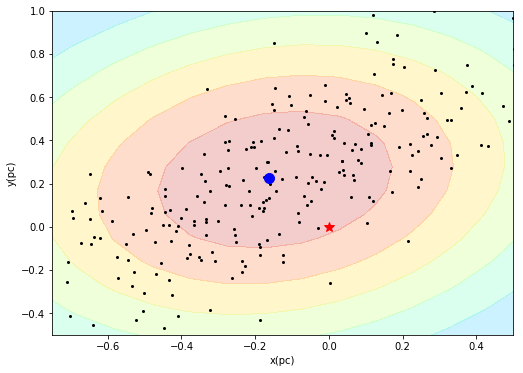

In [357]:
fig,axs=subPlots([1])

ax=axs[0][0]

ip=14 #The best
#ip=0
sx=rnom[ip,0]*np.cos(rnom[ip,1]);sy=rnom[ip,0]*np.sin(rnom[ip,1]);sz=rnom[ip,2]
ax.plot(sx*0,sy*0,'r*',ms=10)

print(rparts[ip,:,0].min())

px=rparts[ip,:,0]*np.cos(rparts[ip,:,1])-sx
py=rparts[ip,:,0]*np.sin(rparts[ip,:,1])-sy
pz=rparts[ip,:,2]-sz
ax.plot(px,py,'ko',ms=2)
ax.plot(px[0],py[0],'bo',ms=10)

#COMPUTE AVERAGE MEAN DISTANCE BETWEEN THE SURROGATE OBJECTS
dmins=[]
for i in range(Npart):
    ri=rparts[ip,i,:3]-np.array([sx,sy,sz])
    ds=[]
    for j in range(Npart):
        if i==j:continue
        rj=rparts[ip,j,:3]-np.array([sx,sy,sz])
        ds+=[np.linalg.norm(ri-rj)]
    dmins+=[np.array(ds).min()]
dmins=np.array(dmins)
dcell=dmins.mean()
print("Average interparticle objects: ",dcell)

#COMPUTE SPH DENSITY
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()
zmin=pz.min();zmax=pz.max()
xs=np.linspace(xmin,xmax,20);dx=xs[1]-xs[0]
ys=np.linspace(ymin,ymax,20);dy=ys[1]-ys[0]
dz=(zmax-zmin)
X,Y=np.meshgrid(xs,ys)
P=np.zeros_like(X)
print("dx=%e,dy=%e,dz=%e\n"%(dx,dy,dz))

rmin=np.array([px.min(),py.min(),pz.min()])
rmax=np.array([px.max(),py.max(),pz.max()])
rcen=np.array([px.mean(),py.mean(),pz.mean()])
h=(np.linalg.norm(rmin-rcen)+np.linalg.norm(rmax-rcen))/2
h=h/2
sigma=wNormalization2(h)

for i,x in enumerate(xs):
    for j,y in enumerate(ys):
        #print(i,j,x,y)
        #ax.plot(x,y,'g+',ms=10)
        p=0.0
        for n in range(Npart):
            rq=np.array([x,y,pz[0]])
            rp=np.array([px[n],py[n],pz[n]])
            d=np.linalg.norm(rq-rp)
            p+=sigma*wFunction2(d,h)*dcell**2*dz
        p/=Npart
        P[j,i]=p

print("Normalization:",P.sum())
c=ax.contourf(X,Y,P,cmap='jet',alpha=0.2)
#plt.colorbar(c)
ax.set_xlabel("x(pc)")
ax.set_ylabel("y(pc)")
ax.set_xlim((-0.75,0.50))
ax.set_ylim((-0.50,1.00))
#ax.grid()

In [690]:
mins=pd.read_csv(BASE_DIR+"surrogatemin.csv")

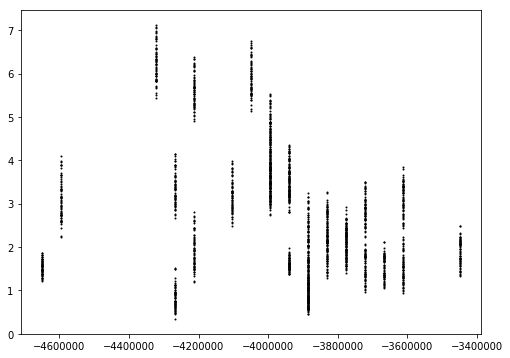

In [692]:
fig,axs=subPlots([1])

ax=axs[0][0]
ax.plot(mins.tmin,mins.dmin,'ko',ms=1)

Text(0,0.5,'$d/d_{\\rm min}$')

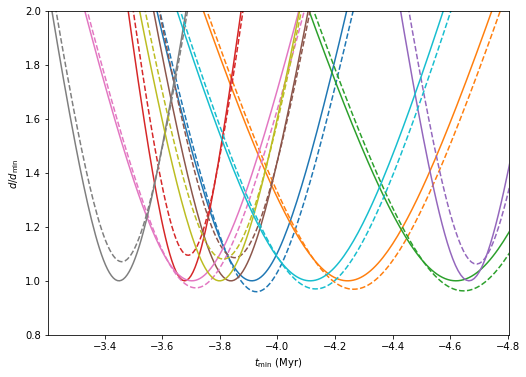

In [766]:
fig,axs=subPlots([1])
ax=axs[0][0]
lista=glob.glob(BASE_DIR+"scratch/surrogatetraj-*.dat")
tmins=[]
for file in lista[::3]:
    traj=np.loadtxt(file)
    ts=traj[:,0]
    Ds=traj[:,1]
    Dlmas=traj[:,-1]
    iargs=Ds.argsort()
    dmin=Ds[iargs][0]
    tmin=ts[iargs][0]
    #print("Minimum:",tmin,dmin)
    tmins+=[tmin]
    line,=ax.plot(ts/1e6,Ds/dmin,'-',ms=2)
    ax.plot(ts/1e6,Dlmas/dmin,'-',ms=2,color=line.get_color(),ls='--')
tmins=np.array(tmins)
ax.set_xlim((tmins.mean()*0.8/1e6,1.2*tmins.mean()/1e6))
ax.set_ylim((0.8,2))
ax.set_xlabel(r"$t_{\rm min}$ (Myr)")
ax.set_ylabel(r"$d/d_{\rm min}$")

## Posterior velicity probability distribution

In [324]:
data=np.loadtxt("ejection-results.data")
aps=np.unique(data[:,0]);na=len(aps)
Mps=np.unique(data[:,1]);nM=len(Mps)
vmean_data=data[:,2].reshape(na,nM)
vstd_data=data[:,3].reshape(na,nM)
print("Number of data points: N(a) = %d, N(Mp) = %d"%(na,nM))
print("Values of ap:",aps)
print("Values of Mp:",Mps)

Number of data points: N(a) = 24, N(Mp) = 21
Values of ap: [ 0.5  0.7  0.9  1.1  1.3  1.5  1.7  1.9  2.1  2.3  2.5  2.7  2.9  3.1  3.3
  3.5  3.7  3.9  4.1  4.3  4.5  4.7  4.9  5.1]
Values of Mp: [ 0.0001      0.0001216   0.00014788  0.00017982  0.00021867  0.00026591
  0.00032336  0.00039322  0.00047818  0.00058148  0.00070711  0.00085987
  0.00104564  0.00127154  0.00154625  0.0018803   0.00228653  0.00278051
  0.00338122  0.0041117   0.005     ]


Text(0,0.5,'$\\Delta v/v$')

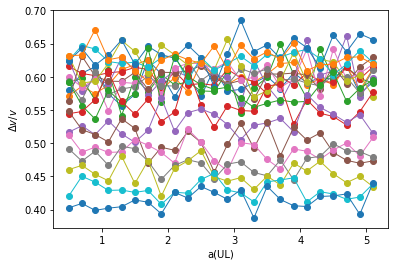

In [325]:
fig=plt.figure()
ax=fig.gca()

dvv=[]
for i,M in enumerate(Mps[::1]):
    ratio=vstd_data[:,i]/vmean_data[:,i]
    avg=ratio.mean()
    std=ratio.std()
    dvv+=[avg]
    line,=ax.plot(aps,ratio,label='Mp = %.1e'%Mps[i],marker='o',lw=1)
    #ax.axhspan(avg-std,avg+std,color=line.get_color(),alpha=0.3)

#ax.legend(loc='best')
ax.set_xlabel('a(UL)')
ax.set_ylabel('$\Delta v/v$')

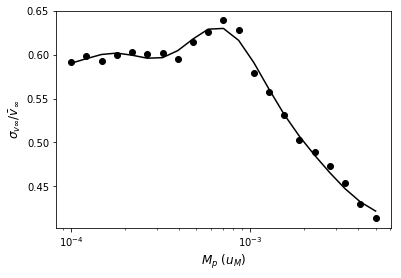

In [326]:
b,a=signal.butter(10,0.325)
sdv=signal.filtfilt(b,a,dvv,padlen=6)
fig=plt.figure()
ax=fig.gca()

ax.plot(Mps,dvv,'ko')
ax.plot(Mps,sdv,'k-')
#ax.plot(Mp,0.5*np.sqrt(1e-3/Mp))

ax.set_xscale('log')
ax.set_ylabel(r"$\sigma_{v\infty}/\bar{v}_\infty$",fontsize=12)
ax.set_xlabel(r"$M_p$ ($u_M$)",fontsize=12)

np.savetxt("ejection-dispersions.data",np.vstack((Mps,sdv)).transpose())

In [327]:
verbose=0

#MONTECARLO
#np.random.seed(3)
iMs=np.arange(len(Mps))
ias=np.arange(len(aps))

if verbose:
    print(np.vstack((iMs,Mps,sdv)).transpose())
    print(np.vstack((ias,aps)).transpose())

Npart=10000

vpgs=[]
vpms=[]
vpxs=[]
for i in range(Npart):
    #Generate a mass
    Mp=10**uniform(np.log10(Mps[0]),np.log10(Mps[-1]))
    iM=iMs[(Mp-Mps)>0][-1]

    #Generate a distance
    ap=uniform(aps[0],aps[-1])
    ia=ias[(ap-aps)>0][-1]
    
    #Estimate the velocity dispersion
    dv=sdv[iM]+(sdv[iM+1]-sdv[iM])/(Mps[iM+1]-Mps[iM])*(Mp-Mps[iM])
    
    #Estimate the mean velocity
    #Position in file
    j=ia*nM+iM
    vmean=data[j,3]
    vstd=vmean*dv
    if verbose:print("Mp=%e, ap=%e, vmean=%e, vstd=%e"%(Mp,ap,vmean,vstd))
    
    #Generate random velocity following a gaussian with mean vmean and vstd
    vg=-1
    while vg<0:vg=np.random.normal(vmean,vstd)
    
    #Generate random velocity followin a Maxwellian with mean vmean
    vm=maxwell.rvs(size=1,scale=vmean)[0]
      
    vpgs+=[vg]
    vpms+=[vm]
    
    if Mp>1e-3:v=vm
    else:v=vg
    vpxs+=[v]
        
    if verbose:
        print("Particle velocity:%e"%v)
        break

In [328]:
nbins=50

hims,vims=np.histogram(vpms,nbins,normed=True)
vmms=(vims[1:]+vims[:-1])/2

higs,vigs=np.histogram(vpgs,nbins,normed=True)
vmgs=(vigs[1:]+vigs[:-1])/2

hixs,vixs=np.histogram(vpxs,nbins,normed=True)
vmxs=(vixs[1:]+vixs[:-1])/2

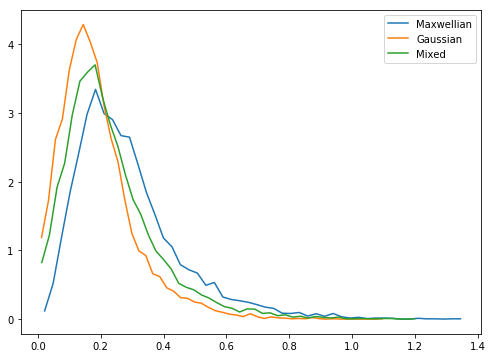

In [329]:
fig,axs=subPlots([1])
ax=axs[0][0]

ax.plot(vmms,hims,label='Maxwellian')
ax.plot(vmgs,higs,label='Gaussian')
ax.plot(vmxs,hixs,label='Mixed')

ax.legend(loc='best')

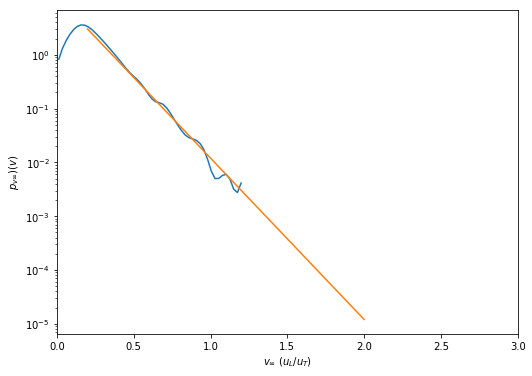

In [408]:
b,a=signal.butter(2,0.325)
shixs=signal.filtfilt(b,a,hixs,padlen=6)
mu=(vmxs*shixs).sum()/shixs.sum()

fig,axs=subPlots([1])
ax=axs[0][0]

#ax.plot(vmxs,hixs,'ko')
ax.plot(vmxs,shixs)

vext=np.linspace(0.2,2.0,100)
hext=12*10**(-3*vext)
ax.plot(vext,hext)

#ax.plot(vmxs,maxwellDistrib(vmxs,mu))
#ax.set_ylim((0,1.1*shixs.max()))
ax.set_xlim((0.,3))
#ax.set_yticks([])

ax.set_xlabel("$v_\infty$ ($u_L/u_T$)")
ax.set_ylabel("$p_{v\infty})(v)$")
#ax.grid()
ax.set_yscale("log")
np.savetxt("ejection-posterior.data",np.vstack(([0.0,0.0],np.vstack((vmxs,hixs)).transpose())))

## Exploring Maxwellian distribution

sigma/mean =  0.42201569295
4.78179296231
4.78730736482


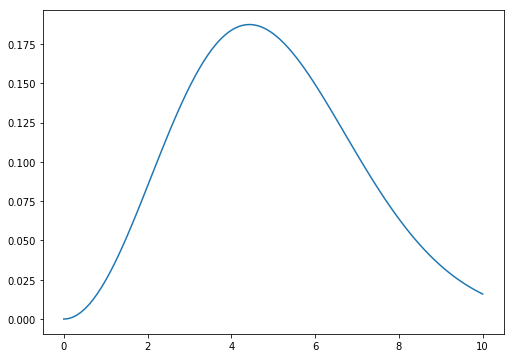

In [876]:
a=1
muf=2*np.sqrt(2/np.pi)
sigmaf=np.sqrt((3*np.pi-8)/np.pi)
print("sigma/mean = ",sigmaf/muf)

a=3.0
xvs=maxwell.rvs(scale=a,size=100000)
print(xvs.mean())
print(2*a*np.sqrt(2/np.pi))

fig,axs=subPlots([1])
ax=axs[0][0]

xes=np.linspace(0,10,100)
yes=maxwellDistrib(xes,mu=5)
ax.plot(xes,yes)

## Evolution of the cloud

In [225]:
data=np.loadtxt(BASE_DIR+"cloudsize.data")

4000000.0

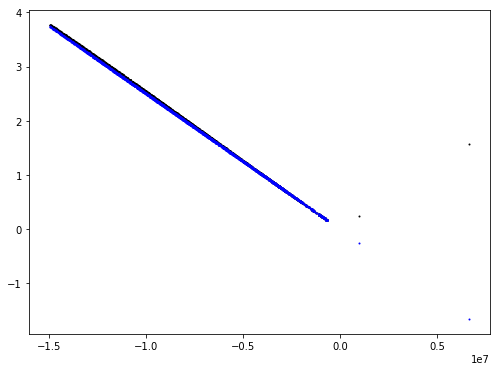

In [316]:
fig,axs=subPlots([1])
ax=axs[0][0]
ts=data[:,0]
rs=data[:,1]
rts=-2.5/1e7*ts
ax.plot(ts,rs,'ko',ms=1)
ax.plot(ts,rts,'bo',ms=1)
1e7/2.5

In [315]:
PARSEC=3e13
YEAR=3.15e7
2.5*PARSEC/(1e7*YEAR)

0.23809523809523808

## Exploring other discoverers objects

In [289]:
inp=pd.read_csv(BASE_DIR+"db/src/Astro/Astro.csv")
print("Number of objects:",len(inp))
db=inp
for cname in ['hip']:
    db[cname]=db[cname].fillna('')
    db[cname]=db[cname].map(str)

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,86,89,90,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of objects: 2341261


In [287]:
rvg=pd.read_csv(BASE_DIR+"db/src/AstroRV.csv")
print("Number of objects:",len(rvg))
db=rvg
for cname in ['hip']:
    db[cname]=db[cname].fillna('')
    db[cname]=db[cname].map(str)

Number of objects: 244589


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,86,90,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [270]:
enc=pd.read_csv(BASE_DIR+"encounters.csv")
print("Number of encounters:",len(enc))
db=enc
for cname in ['hip']:
    db[cname]=db[cname].fillna('')
    db[cname]=db[cname].map(str)

Number of encounters: 242793


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (21,106,110,113,114) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [272]:
can=pd.read_csv(BASE_DIR+"candidates.csv")
db=can
for cname in ['hip']:
    db[cname]=db[cname].fillna('')
    db[cname]=db[cname].map(str)
print("Number of candidates:",len(can))

Number of candidates: 284


In [273]:
pro=pd.read_csv(BASE_DIR+"progenitors.csv")
db=pro
for cname in ['hip']:
    db[cname]=db[cname].fillna('')
    db[cname]=db[cname].map(str)
print("Number of progenitors:",len(pro))

Number of progenitors: 107


In [284]:
#References: (1) Portegies et al. (2017), (2) Dybczynski et al. (2017)
objs=[
    dict(
        ref="(1)",
        cat="tycho2_id",
        id="4742-1027-1"
    ),
    dict(
        ref="(1)",
        cat="tycho2_id",
        id="2402-1097-1"
    ),
    dict(
        ref="(1)",
        cat="tycho2_id",
        id="7207-1734-1",
    ),
    dict(
        ref="(1)",
        cat="tycho2_id",
        id="5317-1558-1",
    ),
    dict(
        ref="(1)",
        cat="tycho2_id",
        id="7580-469-1"
    ),
    dict(
        ref="(2)",
        cat="tycho2_id",
        id="5325-1808-1"
    ),
    dict(
        ref="(2)",
        cat="hip",
        id="107556"
    ),
    dict(
        ref="(2)",
        cat="hip",
        id="113020"
    ),
    dict(
        ref="(2)",
        cat="hip",
        id="3757"
    ),
    dict(
        ref="(2)",
        cat="hip",
        id="3829"
    ),
    dict(
        ref="(2)",
        cat="tycho2_id",
        id="151-860-1"
    ),
    dict(
        ref="(2)",
        cat="tycho2_id",
        id="5009-283-1"
    ),
    dict(
        ref="(2)",
        cat="hip",
        id="981"
    ),
]

In [297]:
for obj in objs:
    cat=obj["cat"]
    oid=obj["id"]
    ref=obj["ref"]
    print("Object: %s %s, ref %s"%(cat,oid,ref))
    cond_inp=inp[cat]==oid
    cond_rvg=rvg[cat]==oid
    cond_enc=enc[cat]==oid
    cond_can=can[cat]==oid
    cond_pro=pro[cat]==oid
    print("\tInput catalog:",cond_inp.sum())
    print("\tRV catalog:",cond_rvg.sum())
    print("\tEncounters:",cond_enc.sum())
    print("\tCandidates:",cond_can.sum())
    print("\tProgenitors:",cond_pro.sum())
    
    if(cond_inp.sum()>0):
        print("\t\tInput catalog: m=",inp[cond_inp][["parallax","parallax_Hip"]].values)
    if(cond_rvg.sum()>0):
        print("\t\tRV catalog: m=",rvg[cond_rvg][["source"]].values)
    if(cond_enc.sum()>0):
        print("\t\tEncounter estimation: tmin,dmin=",enc[cond_enc][["tmin","dmin"]].values)
    if(cond_can.sum()>0):
        print("\t\tCandidate estimation: tmin,dmin=",can[cond_can][["tmin","dmin"]].values)

Object: tycho2_id 4742-1027-1, ref (1)
	Input catalog: 1
	RV catalog: 1
	Encounters: 1
	Candidates: 0
	Progenitors: 0
		Input catalog: m= [[ 7.30040927         nan]]
		RV catalog: m= [['gaia:::']]
		Encounter estimation: tmin,dmin= [[ -3.09653000e+06   3.19633000e+01]]
Object: tycho2_id 2402-1097-1, ref (1)
	Input catalog: 1
	RV catalog: 0
	Encounters: 0
	Candidates: 0
	Progenitors: 0
		Input catalog: m= [[ nan  nan]]
Object: tycho2_id 7207-1734-1, ref (1)
	Input catalog: 1
	RV catalog: 1
	Encounters: 1
	Candidates: 0
	Progenitors: 0
		Input catalog: m= [[ 1.0139676        nan]]
		RV catalog: m= [['gaia:::']]
		Encounter estimation: tmin,dmin= [[  9.79960000e+06   9.23598000e+02]]
Object: tycho2_id 5317-1558-1, ref (1)
	Input catalog: 1
	RV catalog: 1
	Encounters: 1
	Candidates: 0
	Progenitors: 0
		Input catalog: m= [[ 3.80469557         nan]]
		RV catalog: m= [['gaia:tycho::']]
		Encounter estimation: tmin,dmin= [[ -7.20263000e+06   1.97282000e+02]]
Object: tycho2_id 7580-469-1, ref (

In [255]:
enc.columns.values

array(['n', 'postarx', 'postary', 'postarz', 'velstarx', 'velstary',
       'velstarz', 'posbodyperix', 'posbodyperiy', 'posbodyperiz',
       'postarperix', 'postarperiy', 'postarperiz', 'd', 'dmin', 'tmin',
       'vrelx', 'vrely', 'vrelz', 'vrel', 'hip', 'tycho2_id', 'ra',
       'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr',
       'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
       'l', 'b', 'ecl_lon', 'ecl_lat', 'Vmag_Hip', 'ra_Hip', 'dec_Hip',
       'parallax_Hip', 'pmra_Hip', 'pmdec_Hip', 'ra_error_Hip',
       'dec_error_Hip', 'parallax_error_Hip', 'pmra_error_Hip',
       'pmdec_error_Hip', 'ra_dec_corr_Hip', 'ra_parallax_corr_Hip',
       'dec_parallax_corr_Hip', 'ra_pmra_corr_Hip',

In [257]:
enc[enc.tycho2_id=='4742-1027-1'][["dmin","tmin"]]

,dmin,tmin
23702,31.9633,-3096530.0


In [258]:
can[can.tycho2_id=='4742-1027-1']

,n,postarx,postary,postarz,velstarx,velstary,velstarz,posbodyperix,posbodyperiy,posbodyperiz,...,ra_simbad,dec_simbad,pmra_simbad,pmdec_simbad,source,RAJ2000,DEJ2000,RV,eRV,CAT


## Wanderer properties

In [299]:
wand=pd.read_csv(BASE_DIR+"wanderer.csv")

In [306]:
vs=np.sqrt(wand.vxgal**2+wand.vygal**2+wand.vzgal**2)
print("Ingress orbit:",vs.mean(),vs.std())

Ingress orbit: 26.2140128118 0.114415653494


In [317]:
100000/206000

0.4854368932038835

In [319]:
4./3*np.pi*0.05**3

0.0005235987755982989

## Candidates

HD 200325

In [420]:
sep=0.5/3600*np.pi/180

In [424]:
dist=52*PARSEC/AU

In [425]:
dist

10427807.486631015

In [426]:
sep_AU=sep*dist
print("Separation in AU:",sep_AU)

Separation in AU: 25.277718667475806


## Lines intersection

In [14]:
verbose=1
UL=1.496e11
UM=2e30
GCONST=6.67e-11
UT=np.sqrt(UL**3/(GCONST*UM))

C=3E5 #km/s
YEAR=365.25*86400 #s
LY=C*YEAR #km
PARSEC=3.2616*LY #km
if verbose:print("1 parsec = %e km"%PARSEC)

#Units
PPY=PARSEC/YEAR 
if verbose:print("1 pc/year = %e km/s"%PPY)

1 parsec = 3.087848e+13 km
1 pc/year = 9.784800e+05 km/s


In [73]:
#Definitions of lines
p1=np.array([0,0,0]);d1=np.array([0,0,1])
p2=np.array([1,0,0]);d2=np.array([0,1,0])

#NEGATIVE TIME
p1=np.array([0.36356,0.25715,0.19122])
d1=np.array([12.45749,8.81218,6.55043])/PPY

p2=np.array([-315.63850559777796434,17.91161785364340275,-358.97660198317771574])
d2=np.array([13.37463,-17.29669,-15.42709])/PPY

#POSITIVE TIME
p1=np.array([0.36356,0.25715,0.19122])
d1=np.array([12.45749,8.81218,6.55043])/PPY

p2=np.array([-139.30549124524108606,8.33167874338618475,-159.60834961035965307])
d2=np.array([40.18291,-45.98836,5.20096])/PPY

#VERY CLOSE
p1=np.array([0.36356,0.25715,0.19122])
d1=np.array([12.45749,8.81218,6.55043])/PPY

p2=np.array([97.57820431496155322,31.89677748438846194,-285.77650953617376217])
d2=np.array([3.28046,5.17166,36.18925])/PPY

#CLOSEST
p1=np.array([0.36356,0.25715,0.19122])
d1=np.array([12.45749,8.81218,6.55043])/PPY

p2=np.array([-14.72541107671365523,73.28576364562140100,-344.02251548758425770])
d2=np.array([9.90856,20.48235,-47.41647])/PPY


dini=np.linalg.norm(p1-p2)
print("Initial distance:",dini)

Initial distance: 352.198738154


<IPython.core.display.Javascript object>


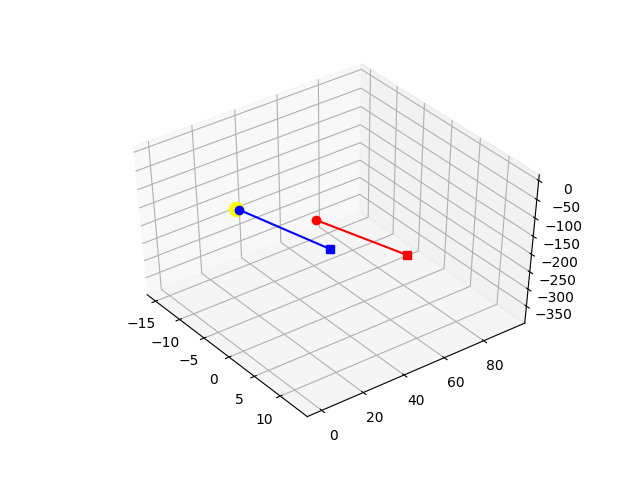

In [74]:
#Plot
ts=np.linspace(0,+1e6,100)
r1s=np.array([p1+d1*t for t in ts])
r2s=np.array([p2+d2*t for t in ts])

fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')

ax.plot([0],[0],[0],'o',color='yellow',ms=10)

ax.plot(r1s[:,0],r1s[:,1],r1s[:,2],'b-') #BLUE IS BODY
ax.plot([r1s[0,0]],[r1s[0,1]],[r1s[0,2]],'bo')
ax.plot([r1s[-1,0]],[r1s[-1,1]],[r1s[-1,2]],'bs')

ax.plot(r2s[:,0],r2s[:,1],r2s[:,2],'r-') #RED IS STAR
ax.plot([r2s[0,0]],[r2s[0,1]],[r2s[0,2]],'ro')
ax.plot([r2s[-1,0]],[r2s[-1,1]],[r2s[-1,2]],'rs')

In [75]:
#Time of minimum distance
dp=p1-p2
dv=d1-d2
dvmag=np.linalg.norm(dv)
tsimin=-np.dot(dp,dv)/(dvmag*dvmag)
print("Minimum time:",tsimin)
dsimin=np.linalg.norm(dp+dv*tsimin)
print("Minimum distance:",dsimin)

Minimum time: -6234767.21446
Minimum distance: 1.79472833146


<IPython.core.display.Javascript object>


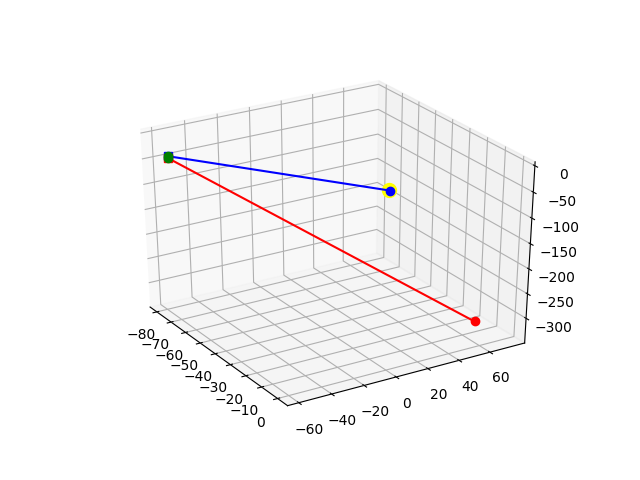

Distance at end: 1.79472833146


In [76]:
#Plot
#tsimin=+1e6
ts=np.linspace(0,tsimin,100)
r1s=np.array([p1+d1*t for t in ts])
r2s=np.array([p2+d2*t for t in ts])

fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')

ax.plot([0],[0],[0],'o',color='yellow',ms=10)
ax.plot(r1s[:,0],r1s[:,1],r1s[:,2],'b-') #BLUE IS BODY
ax.plot([r1s[0,0]],[r1s[0,1]],[r1s[0,2]],'bo')
ax.plot([r1s[-1,0]],[r1s[-1,1]],[r1s[-1,2]],'bs')

ax.plot(r2s[:,0],r2s[:,1],r2s[:,2],'r-') #RED IS STAR
ax.plot([r2s[0,0]],[r2s[0,1]],[r2s[0,2]],'ro')
ax.plot([r2s[-1,0]],[r2s[-1,1]],[r2s[-1,2]],'rs')

ax.plot([r1s[-1,0],r2s[-1,0]],[r1s[-1,1],r2s[-1,1]],[r1s[-1,2],r2s[-1,2]],'go-')
print("Distance at end:",np.linalg.norm(r1s[-1,:]-r2s[-1,:]))

In [84]:
data=pd.read_csv(BASE_DIR+"candidates-Voyager1.csv")
data.sort_values(by="dmin")[["hip","tycho2_id","dmin","tmin"]]

,hip,tycho2_id,dmin,tmin
48,20917.0,NaN,0.410846,463575.0
63,74913.0,NaN,0.682702,9434260.0
61,61481.0,NaN,1.409320,1841640.0
77,78840.0,NaN,1.701200,3748900.0
100,65378.0,NaN,2.063360,1773030.0
95,98069.0,NaN,2.196560,3795160.0
81,87768.0,NaN,2.247510,444388.0
65,96184.0,NaN,2.898730,1030470.0
73,93743.0,NaN,3.205220,919951.0
109,98110.0,NaN,3.248490,990679.0


## Animación en 3D

In [150]:
stars=pd.read_csv(BASE_DIR+"simstars-Oumuamua.csv")
stars.fillna('',inplace=True)
data=pd.read_csv(BASE_DIR+"simulation-Oumuamua.csv")

In [174]:
ntimes=len(data)
nobjs=int((data.shape[1]-2)/6)
print(data.shape)
print("Ntimes = ",ntimes)
print("Nobjs = ",nobjs)

(1000, 662)
Ntimes =  1000
Nobjs =  110


In [175]:
ts=data["t"].values
robjs=np.zeros((nobjs,ntimes,3))
for i in range(nobjs):
    if i==2:continue
    pref="x%d"%i
    robjs[i]=np.vstack((data["%s_0"%pref].values,data["%s_1"%pref].values,data["%s_2"%pref].values)).transpose()
rsuns=robjs[0]
rnoms=robjs[1]

<IPython.core.display.Javascript object>


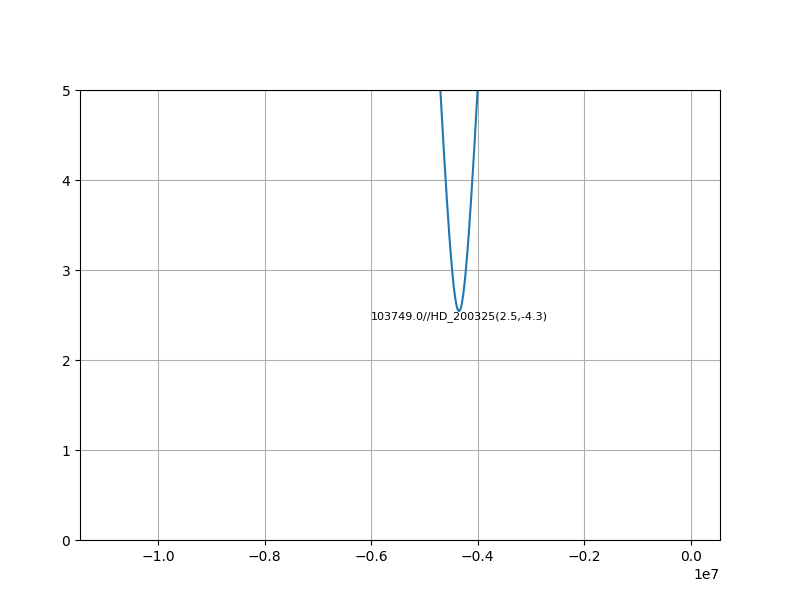

In [178]:
fig,axs=subPlots([1])

ax=axs[0][0]

#ax.plot(ts,rsun[:,0])
k=-1
for istar in range(nobjs):
    if istar<3:continue
    k+=1
    star=stars.iloc[k]
    label="%s/%s/%s"%(star.hip,star.tycho2_id,star.name_simbad)
    #print(label)
    
    #
    #if star.tycho2_id=="6995-570-1":pass
    if star.name_simbad=='HD_200325':pass
    else:continue
    
    dstar=np.array([np.linalg.norm(rnoms[it,:]-robjs[istar,it,:]) for it in range(ntimes)])
    isort=dstar.argsort()
    dmin=dstar[isort[0]]
    tmin=ts[isort[0]]
    #print("Star %d (%s): tmin = %e, dmin = %e"%(k,label,tmin,dmin))
    ax.plot(ts,dstar)
    ax.text(tmin,dmin,label+("(%.1f,%.1f)"%(dmin,tmin/1e6)),rotation=0,fontsize=8,ha='center',va='top')
    #if k>5:break

ax.set_ylim((0,5))
ax.grid()